# AI ODYSSEY: LSTM ASSIGNMENT

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

## TEXT PRE-PROCESSING FOR NLP

In [2]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv


**Import the dataset.**

In [3]:
#ENTER YOUR CODE HERE
import pandas as pd
import numpy as np
datas = pd.read_csv("new_dataset.csv")
datas.head()

,sentiment,text
0,Negative,@xnausikaax oh no! where did u order from? tha...
1,Negative,A great hard training weekend is over. a coup...
2,Negative,"Right, off to work Only 5 hours to go until I..."
3,Negative,I am craving for japanese food
4,Negative,Jean Michel Jarre concert tomorrow gotta work...


**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


In [4]:
#ENTER YOUR CODE HERE
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
l = []

for i in datas['text']:
    words = word_tokenize(i)
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    j = " ".join(filtered_sentence)
    l.append(j)

# Apply the function to the dataset
datas.drop(['text'],axis = 1)
datas['text'] = l
datas.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,sentiment,text
0,Negative,@ xnausikaax oh ! u order ? 's horrible
1,Negative,great hard training weekend . couple days rest...
2,Negative,"Right , work 5 hours go 'm free xD"
3,Negative,craving japanese food
4,Negative,Jean Michel Jarre concert tomorrow got ta work...


**Next, we'll remove some other info we dont need right now, like the handle names.**

In [5]:
#ENTER YOUR CODE HERE
import re
l = []
for i in datas['text']:
    words = word_tokenize(i)
    filtered_sentence = []
    for i in range (len(words)):
      if words[i][0] != '@' and words[i-1][0] != '@':
        filtered_sentence.append(words[i])
    j = " ".join(filtered_sentence)
    l.append(j)

datas.drop(['text'],axis = 1)
datas['text'] = l
datas.head()

,sentiment,text
0,Negative,oh ! u order ? 's horrible
1,Negative,great hard training weekend . couple days rest...
2,Negative,"Right , work 5 hours go 'm free xD"
3,Negative,craving japanese food
4,Negative,Jean Michel Jarre concert tomorrow got ta work...


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [6]:
#ENTER YOUR CODE HERE
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Function to perform stemming on a list of words
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Apply the handle removal and stemming to the dataset
processed_dataset = []
for sentence in datas['text']:
    words = sentence.split()
    stemmed_words = stem_words(words)
    processed_sentence = " ".join(stemmed_words)
    processed_dataset.append(processed_sentence)

datas.drop(['text'],axis = 1)
datas['text'] = processed_dataset
datas.head()

,sentiment,text
0,Negative,oh ! u order ? 's horribl
1,Negative,great hard train weekend . coupl day rest let ...
2,Negative,"right , work 5 hour go 'm free xd"
3,Negative,crave japanes food
4,Negative,jean michel jarr concert tomorrow got ta work ...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


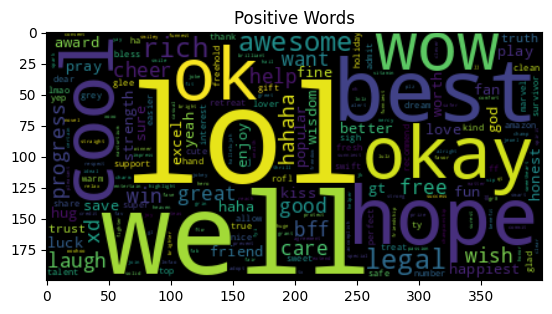

In [7]:
#ENTER YOUR CODE HERE
from wordcloud import WordCloud
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
cleaned_lines = dict()
positive_words = []
negative_words = []
words = []
for i in datas['text']:
  l = i.split()
  for k in l:
    words.append(k)

for r in words:
  neg_polarity = sia.polarity_scores(r)['neg']
  pos_polarity = sia.polarity_scores(r)['pos']
  cpd_polarity = sia.polarity_scores(r)['compound']
  sentiment = (neg_polarity + pos_polarity)*cpd_polarity
  if (sentiment != 0):
    cleaned_lines[r] = sentiment

for key,value in cleaned_lines.items():
  if (value > 0):
    positive_words.append(key)
  else:
    negative_words.append(key)
colour_words_dict = {'green':positive_words , 'red':negative_words}
s = ''
for i in positive_words:
  s +=i
  s += ' '
wc = WordCloud(collocations = False,background_color = 'black').generate(s)
plt.figure
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Positive Words')
plt.show()


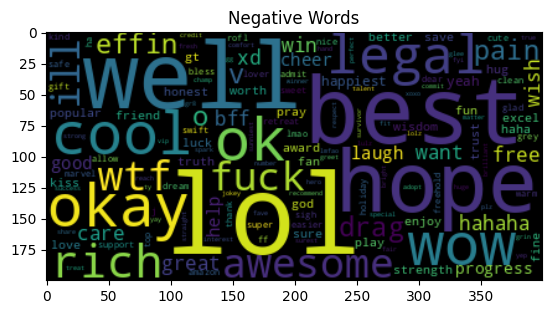

In [8]:
#ENTER YOUR CODE HERE
for i in negative_words:
  s +=i
  s += ' '
wc = WordCloud(collocations = False,background_color = 'black').generate(s)
plt.figure
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Negative Words')
plt.show()

**I'd like to point out that 'Work' is bigger in the negative words display than it is in the positive words one.**

## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [9]:
#ENTER YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datas['text'], datas['sentiment'], test_size=0.1, random_state=42)
print("Training Set Size:",X_train.shape[0])
print("Test Set Size:",X_test.shape[0])

Training Set Size: 9000
Test Set Size: 1000


**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [10]:
#ENTER YOUR CODE HERE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert the training and test data to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:',vocab_size)

Vocabulary Size: 11044


**Now transform the training and testing word sequences.**

In [11]:
#ENTER YOUR CODE HERE
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Training data:')
print(X_train_seq[0])
print('Testing data: ')
X_test_seq[0]

Training data:
[29, 373, 4311, 728, 1040, 728, 17, 218, 7, 4312]
Testing data: 


[310, 628, 1840, 2219, 119, 10]

**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [12]:
#ENTER YOUR CODE HERE
max_length = max(len(seq) for seq in X_train_seq + X_test_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='pre')
print('Training data:')
print(X_train_pad[0])
print('Testing data: ')
X_test_pad[0]

Training data:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   29  373 4311  728
 1040  728   17  218    7 4312]
Testing data: 


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  310,  628, 1840, 2219,  119,
         10], dtype=int32)

**Label encode y.**

In [13]:
#ENTER YOUR CODE HERE
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print("The training labels:")
y_train_encoded
print("The testing labels:")
y_test_encoded

The training labels:
The testing labels:


array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [14]:
import tensorflow as tf
import numpy as np
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-06-26 15:58:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-26 15:58:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-26 15:58:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [15]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
word_index = tokenizer.word_index
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length,trainable=False)


Found 400000 word vectors.


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previou code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [16]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

#ENTER YOUR CODE HERE
model = Sequential([
    Input(shape=(max_length)),
    embedding_layer,
    SpatialDropout1D(0.2),
    Conv1D(64, 5, activation='relu'),
    Bidirectional(LSTM(64)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 300)           3313200   
                                                                 
 spatial_dropout1d (Spatial  (None, 34, 300)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 30, 64)            96064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0

**Train the model on the train split, and validate it on the test split.**

In [17]:
#ENTER YOUR CODE HERE
history = model.fit(X_train_pad, y_train_encoded,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)

Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 0.6902 - accuracy: 0.5307 - val_loss: 0.6704 - val_accuracy: 0.6250
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 7s 792ms/step - loss: 0.6509 - accuracy: 0.6375 - val_loss: 0.6229 - val_accuracy: 0.6528
Epoch 3/10
8/8 [==============================] - 8s 988ms/step - loss: 0.6116 - accuracy: 0.6697 - val_loss: 0.6039 - val_accuracy: 0.6594
Epoch 4/10
8/8 [==============================] - 11s 1s/step - loss: 0.5865 - accuracy: 0.6901 - val_loss: 0.6143 - val_accuracy: 0.6589
Epoch 5/10
8/8 [==============================] - 8s 886ms/step - loss: 0.5903 - accuracy: 0.6849 - val_loss: 0.5904 - val_accuracy: 0.6711
Epoch 6/10
8/8 [==============================] - 6s 749ms/step - loss: 0.5657 - accuracy: 0.7024 - val_loss: 0.5834 - val_accuracy: 0.6789
Epoch 7/10
8/8 [==============================] - 11s 1s/step - loss: 0.5526 - accuracy: 0.7113 - val_loss: 0.5808 - val_accuracy: 0.6839
Epoch 8/10
8/8 [==============================] - 10s 1s/step - loss: 0.5389 - accuracy: 0.7196 - val_loss: 0.5749 - val_accuracy: 0.6822
Epoch 9/10
8/8 [=====================

**Let's visualise the model's training history now.**

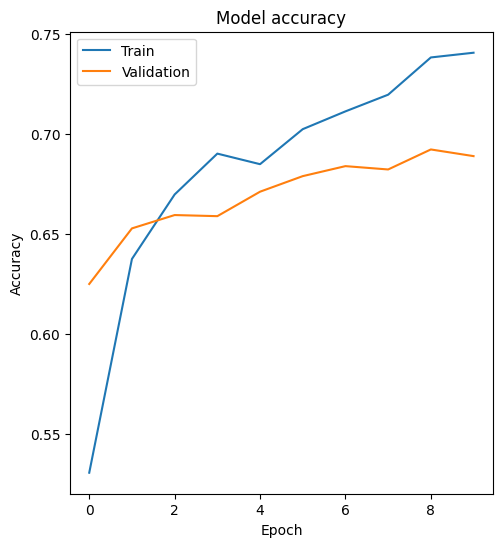

In [18]:
#ENTER YOUR CODE HERE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

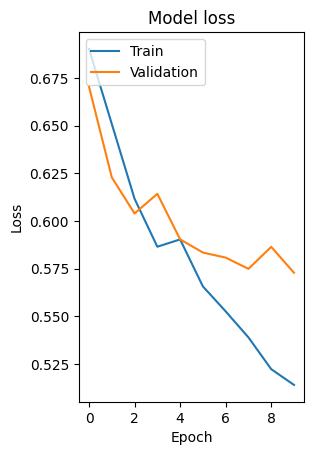

In [19]:
#ENTER YOUR CODE HERE
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


**Lets see what the accuracy of the model is.**

In [20]:
#ENTER YOUR CODE HERE
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_classes))

32/32 [==============================] - 3s 33ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       492
           1       0.69      0.65      0.67       508

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



**Take a random input sequence from the text series. First predict on it nd gets its sentiment. Then decode the string using the tokenizer, etc. you've developed and print the string as well.**

In [21]:
#ENTER YOUR CODE HERE
import random

# Select a random sequence from the test set
random_index = random.randint(0, len(X_test_pad) - 1)
random_sequence = X_test_pad[random_index:random_index + 1]
print("The chosen sequence is:",random_sequence)
# Predict the sentiment for this sequence
prediction = model.predict(random_sequence)
predicted_class = (prediction > 0.5).astype("int32")[0][0]

# Decode the sequence back to the original string
reverse_word_index = {value: key for key, value in tokenizer.word_index.items()}
decoded_sequence = " ".join([reverse_word_index.get(i, '?') for i in random_sequence[0] if i != 0])

# Print the prediction

print(f"Predicted sentiment: {'Positive' if predicted_class == 1 else 'Negative'}")

The chosen sequence is: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 2334]]
1/1 [==============================] - 0s 52ms/step
Predicted sentiment: Negative


In [22]:
#ENTER YOUR CODE HERE
print(f"Original string: {decoded_sequence}")

Original string: ground


**We can try this on a random string as well.**

In [41]:
#ENTER YOUR CODE HERE
input_str="I hate everyone on earth!"

l = []


words = word_tokenize(input_str)
filtered_sentence = [word for word in words if word.lower() not in stop_words]
j = " ".join(filtered_sentence)
l.append(j)
print("After removal of stopwords:",l[0])
s = ''
for i in l[0]:
  if (i == '!' or i =='?' or i == ','):
    continue
  s+=i
m = []
print("After removal of punctuation:",s)
print("After stemming:",s)
s = tokenizer.texts_to_sequences(words)
s.remove([])
s.remove([])
print("After tokenization:",s)
for i in s:
  m.append(i[0])
l = []
l.append(m)
l = pad_sequences(l, maxlen=max_length, padding='pre')
print("After padding:",l)
prediction = model.predict(l)
predicted_class = (prediction > 0.5).astype("int32")[0][0]

# Decode the sequence back to the original string
reverse_word_index = {value: key for key, value in tokenizer.word_index.items()}
decoded_sequence = " ".join([reverse_word_index.get(i, '?') for i in random_sequence[0] if i != 0])

# Print the prediction

print(f"Predicted sentiment: {'Positive' if predicted_class == 1 else 'Negative'}")

After removal of stopwords: hate everyone earth !
After removal of punctuation: hate everyone earth 
After stemming: hate everyone earth 
After tokenization: [[370], [83], [2782], [2383]]
After padding: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  370   83 2782 2383]]
1/1 [==============================] - 0s 51ms/step
Predicted sentiment: Negative


After removal of stopwords: 0    I hate everyone earth!
dtype: object
After removal of punctuation: 0    I hate everyone earth 
dtype: object
After stemming: 0    i hate everyone earth 
dtype: object
After tokenization: [[1, 100, 138, 2693]]
After padding: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    1  100  138 2693]]
1/1 [==============================] - 0s 58ms/step
The predicted sentiment is: ['Negative']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## GOOD JOB!